# Trabalho Prático 2 - Disciplina de Machine Learning

**Nome: Daniel Pimentel Kansaon**

**Matrícula: 2018718007**


`O objetivo deste trabalho é de praticar o uso de Convolutional Neural Networks(CNN) e de Transfer Learning.  Neste trabalho foi construído uma Rede neural Convolucional (CNNs) para classificação de imagens. Ao todo, 2 CNNs utilizaram o conceito de Transfer Learning. De maneira geral, a melhor rede apresentou uma acurácia acima de 96%.`

# Bibliotecas

In [0]:
import matplotlib as mpl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display
from IPython.display import Markdown

from sklearn import metrics

from keras import datasets
from keras import layers
from keras import optimizers
from keras import models

from keras import utils

# Remove os alertas retornados pelo TensorFlow
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

def printmd(s):
    display(Markdown(s))

# Constantes

Aqui são definidas as constantes que serão utilizadas no trabalho.

In [0]:
ULTIMOS_DIGITOS_MATRICULA = [0, 7] #Os dois últimos digitos da matrícula. Classe 7 = cavalo e Classe 0 = Avião

N_CLASSES = 10 # Existe 10 tipo de imagens, ou seja, 10 classes diferentes

NUM_BATCH_SIZE = 128 # A quantidade de exemplos que serão propagados pela rede até a correção dos erros pelo backpropagation

NUM_EPOCHS = 20 # Quantidade de epocas que a rede neural será executada

#Métodos Comuns

Os métodos comuns estão relacionados com a geração dos gráficos. Como serão chamados várias vezes, o método genérico proporciona uma melhor organização evitando redundância.

In [0]:
def plot_acc(history):
    # Gera graficos do resultado do treino
    mpl.rc("font", **{"size": 14})
    fig, axes = plt.subplots(1, 2, figsize=(17, 7))

    # Loss
    axes[0].plot(range(1, len(history.history["loss"])+1), history.history["loss"], 
    label="Train Loss", color="royalblue", lw=3)
    axes[0].plot(range(1, len(history.history["val_loss"])+1), history.history["val_loss"], 
    label="Test Loss", color="forestgreen", lw=3)
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_xticks(range(1, len(history.history["acc"])+1))
    axes[0].legend()

    # Accuracy
    axes[1].plot(range(1, len(history.history["acc"])+1), history.history["acc"], 
    label="Train ACC", color="royalblue", lw=3)
    axes[1].plot(range(1, len(history.history["val_acc"])+1), history.history["val_acc"], 
    label="Teste ACC", color="forestgreen", lw=3)
    axes[1].set_ylabel("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_xticks(range(1, len(history.history["acc"])+1))
    axes[1].legend()
    plt.show()

In [0]:
def plot_confusion_matrix(model, x_train, y_train):    
    # Predições
    y_proba = model.predict(x_train)
    y_pred = np.argmax(y_proba, axis=1)

    # Labels (desfaz o one-hot encode)
    y_true = np.argmax(y_train, axis=1)

    cm = metrics.confusion_matrix(y_true, y_pred)
    classes = list(range(1, 11))
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=classes, yticklabels=classes,
    title="Matriz de Confusão",
    ylabel="Real",
    xlabel="Predito")

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2. else "black")
    fig.tight_layout()
    plt.show()

# Obtendo Dados

O CIFAR-10 é uma base de dados online que contém aproximadamente 80 milhões de imagens rotuladas. No trabalho usaremos as imagens ali existentes para treinar uma modelo de aprendizado (CNN). Nesta parte do código carregamos as imagens contidas na base para vetores. Utilizando esta sintaxe é possível obter os dados já separados em treino e teste. Como no trabalho não terá a etapa de validação cruzada, as imagens na ordem retornada irão compor a etapa de treinamento e teste.

In [0]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Exemplo das imagens

Abaixo temos os exemplos das imagens seguido dos dígitos existentes na base de dados. Note que temos imagens distintas como: avião e cavalo ou navio e sapo. Mas também existem as imagens com uma maior similaridade, como é o exemplo de: cachorro e gato. O principal desafio do modelo é encontrar padrões que diferencie as imagens semelhantes.

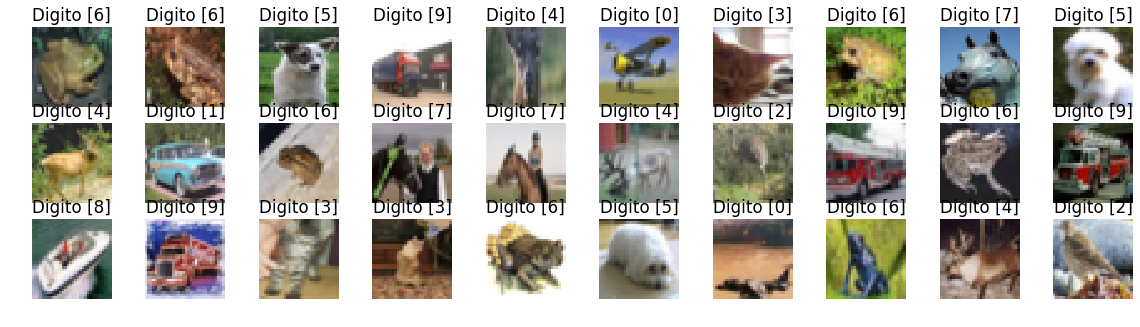

In [100]:
n_rows = 3
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, x_train.shape[0])
        axes[i][j].imshow(x_train[img_i], cmap="gray")
        axes[i][j].set_title("Digito {}".format(y_train[img_i]))
        axes[i][j].axis("off")
plt.show()

# Obtendo o formato da imagem

Nesta parte obtemos o formato das imagens, que será utilizado para especificar o tamanho esperado na camada de Input da rede (CNN). Além disso, os vetores de labels são convertidos para o formato one-hot encoding, que permite com que os algoritmos façam um trabalho melhor na predição.

In [0]:
#Obtêm o formato da imagem
img_shape = x_train.shape[1:]

#Converte o vetor obtido no dataset para ONE-HOT ENCODING
y_train = utils.to_categorical(y_train, N_CLASSES)
y_test = utils.to_categorical(y_test, N_CLASSES)

#Normalização

Sabe-se as imagens da base de dados são coloridas RGB (255, 255, 255). Assim, antes de executar os algoritmos é feita a normalização nas imagens, dividindo cada espectro por 255, que é o máximo que um espectro pode ter. Assim, garantimos que as figuras estão normalizadas facilitando no processo de aprendizado, evitando com que o algoritmo dê um enfoque em imagens que com valores altos de RGB.

In [0]:
x_train = x_train/255
x_test = x_test/255

# Separando dados em parte A e B

Com base na descrição do problema, aqui os dados são separados em duas partes, A e B. Sendo que a parte A contém 8 das 10 classes de imagens existentes. Já a parte B contém as outras 2 classes (que foram escolhidas com base nos últimos dígitos da matrícula). A parte B contém imagens de Cavalo (7) e Avião (0).

In [0]:
#Verifica se a imagem(vector) é da classe contida no número de matrícula
def verify_class(vector):
    for i in ULTIMOS_DIGITOS_MATRICULA:
        if (vector[i] == 1.0):
            return 1
    return 0

#Obtêm os indices das imagens que são da classe [0 ou 7], que são os últimos digitos da matricula.
index_train_digit = list(filter(lambda x: verify_class(y_train[x]) == 1, range(y_train.shape[0])))
index_test_digit = list(filter(lambda x: verify_class(y_test[x]) == 1, range(y_test.shape[0])))

#Cria a parte B dos dados
b_x_train = x_train[index_train_digit]
b_y_train = y_train[index_train_digit]
b_x_test = x_test[index_test_digit]
b_y_test = y_test[index_test_digit]

#Cria os dados da parte A, removendo os indices presentes em B
a_x_train = np.delete(x_train, index_train_digit, 0)
a_y_train = np.delete(y_train, index_train_digit, 0)
a_x_test = np.delete(x_test, index_test_digit, 0)
a_y_test = np.delete(y_test, index_test_digit, 0)

# Definindo CNN

Nesta etapa é definido o modelo que será utilizado para a classificação de imagens. O modelo se trata de uma rede neural artificial do tipo feed-forward, que é a **CNN (Convolutional Neural Network)**. Este modelo é bastante utilizada para problemas relacionados com imagens, pois suas camadas de convolução são bastante eficientes para extração de features em imagens. Neste tipo de rede, as camadas de convolução seguidas das camadas de pooling ajudam o modelo focar nas partes importantes da imagens, ajudando a classificar com uma maior eficiência.

Em linhas gerais, o modelo é simples. Inicia com uma camada de **input**, que recebe uma imagem com o formato especificado (img_shape) e passa para as próximas camadas. Em sequência temos **duas etapas** seguidas de **convolução e pooling** que são alternadas por uma camada de **dropout**,  que ajuda a controlar o overfitting da rede. As camadas de convolução possuem **filtros de tamanho (3,3)** e uma função de ativação **Relu**, muito comumente utilizada em redes deste tipo. Ao todo existem 4 camadas de convolução, com **32, 64, 64, 64 filtros**.

Após as convoluções existem **2 camadas densas totalmente conectadas** que são intercaladas por 2 camadas de dropout. A primeira camada densa possui uma dimensão de saída de 128 que é conectada por outra camada densa com saída igual a 10, que representa a quantidade de classes existentes. Por fim, a última camada possui uma função de ativação diferente, pois precisa retornar a probabilidade de ser de cada classe, assim foi utilizado a **softmax**.

A função **load_cnn_model** possui dois parâmetros, que basicamente dizem se a última e penúltima camada densa será treinada ou não.

In [0]:
def load_cnn_model(train_weight=True, train_penult_dense=True):
    model_input = layers.Input(shape=img_shape, name="Input")        
    
    # 2 camadas de convolucao e 1 de pooling
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv1", trainable=train_weight)(model_input)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv2", trainable=train_weight)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="Pool1", trainable=train_weight)(x)
            
    # 1º Dropout - Probabilidade de remover cada neuronio, ajudando a controlar o overffitig
    x = layers.Dropout(0.25, name="Dropout1")(x)
    
    # 2 camadas de convolucao e 1 de pooling, semelhante a anterior
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv3", trainable=train_weight)(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv4", trainable=train_weight)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="Pool2", trainable=train_weight)(x)
    
    # 2º Dropout - Probabilidade de remover cada neuronio, ajudando a controlar o overffitig
    x = layers.Dropout(0.25, name="Dropout2")(x)
    
    # Camada que "achata" a saída das camadas de convolução para usar nas camadas totalmente conectadas
    x = layers.Flatten(name="Flatten", trainable=train_weight)(x)      
         
    # Camada densa totalmente conectada
    x = layers.Dense(128, activation="relu", name="Dense1", trainable=train_penult_dense)(x)    
    
    # 3º Dropout - Probabilidade de remover cada neuronio, ajudando a controlar o overffitig
    x = layers.Dropout(0.50, name="Dropout3")(x)
    
    # Ultima camada densa com uma função de ativação softmax, que tem como saida a probabilidade de cada classe
    model_output = layers.Dense(N_CLASSES, activation='softmax', name="OutpuLayer")(x)
        
    model = models.Model(model_input, model_output)
    model.summary()
    
    return model

O método abaixo, dado um modelo criado e os dados, treina e retorna o resultado da rede. Vale ressaltar o regularizador  **decay=1e-6**  que penaliza grandes pesos na hora de atualizar os valores com o back propagation foi extremamente importante para que os modelos apresentassem uma precisão satisfatória. 

In [0]:
def execute_model(model, x_train, y_train, x_test, y_test):
    
    # O Adam algoritmo é uma otimização do tradicional Stochastic Gradient Descent. Geralmente alcanca um bom resultado mais rapidamente.
    optimizer = optimizers.Adam(lr=0.001, decay=1e-6)

    # Compila o modelo e escolhe a funcao de perda e a métrica utilizada, no caso, acuracia.
    model.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    # Treinando a rede
    result = model.fit(x_train, y_train, batch_size=NUM_BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_test, y_test))
    
    return result

# 1 - Treinando a parte (A) dos dados

Nesta parte carregamos o modelo criado para executarmos na primeira parte dos dados, a parte A. Ao todo a rede tem 618,954 parâmetros para treinar.

In [106]:
cnn_model_a = load_cnn_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 16, 16, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 64)        36928     
__________

Após ter sido carregado executamos o modelo utilizando 20 épocas.

In [107]:
history_a = execute_model(cnn_model_a, a_x_train, a_y_train, a_x_test, a_y_test)

Train on 40000 samples, validate on 8000 samples
Epoch 1/20
40000/40000 [==============================] - 20s 498us/step - loss: 1.5379 - acc: 0.4082 - val_loss: 1.2214 - val_acc: 0.5473
Epoch 2/20
40000/40000 [==============================] - 14s 347us/step - loss: 1.1746 - acc: 0.5586 - val_loss: 1.0195 - val_acc: 0.6131
Epoch 3/20
40000/40000 [==============================] - 14s 345us/step - loss: 1.0473 - acc: 0.6120 - val_loss: 0.8783 - val_acc: 0.6817
Epoch 4/20
40000/40000 [==============================] - 14s 346us/step - loss: 0.9419 - acc: 0.6548 - val_loss: 0.8044 - val_acc: 0.7035
Epoch 5/20
40000/40000 [==============================] - 14s 350us/step - loss: 0.8618 - acc: 0.6864 - val_loss: 0.7230 - val_acc: 0.7399
Epoch 6/20
40000/40000 [==============================] - 14s 349us/step - loss: 0.7976 - acc: 0.7121 - val_loss: 0.6983 - val_acc: 0.7489
Epoch 7/20
40000/40000 [==============================] - 14s 348us/step - loss: 0.7407 - acc: 0.7337 - val_loss: 0.6

## 1.2 - Resultado parte A

A primeira observação a ser feita é em relação a precisão. Em linhas gerais o modelo apresenta uma precisão aceitavél **(80,90% de precisão)**, além de que o modelo não sofre do overffiting, com pode ser visto na figura da direita, em que o erro a precisão no treino é acompanhada da precisão no teste. Assim que o modelo atingiu uma boa taxa de precisão se overffiting. Nas figuras abaixo é possível notar a **precisão** do modelo juntamente com a **loss** em cada época executada.

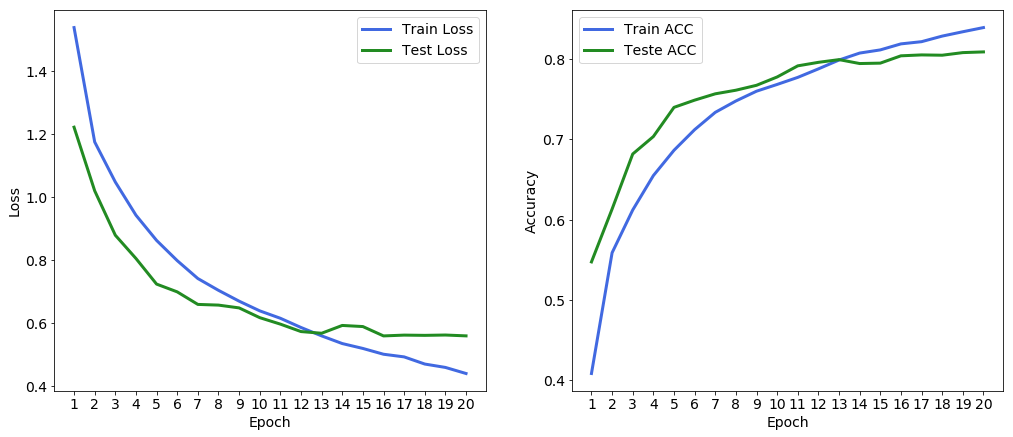

In [108]:
plot_acc(history_a)

Já observando mais detalhadamente como o modelo classifica as imangens,  é possível notar na matriz de confusão que na maioria dos casos o modelo consegue acertar corretamente as classes. Mas se observarmos com calma, nota-se que o modelo confunde alguns exemplos de cachorro (5) com gato (3). De fato, as imagens possui um grau de dificuldade maior para classificar devido a similaridade existente. Mas de maneira geral o modelo classificou corretamente todas as imagens apresentando apenas algumas confusões. Com isso, de maneira geral o modelo acerta corretamente as classes, além de que as confusões apresentadas já eram de se esperar devido a semelhança existente nas classes.

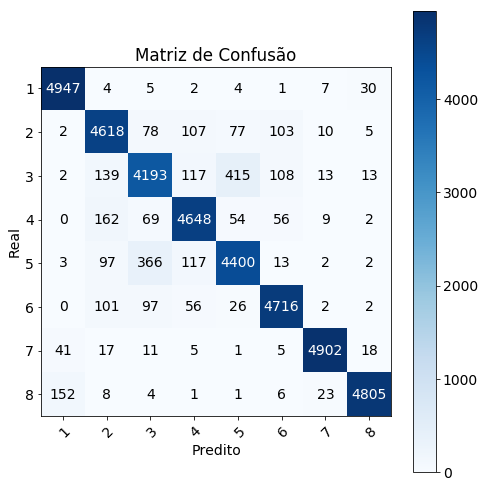

In [85]:
plot_confusion_matrix(cnn_model_a, a_x_train, a_y_train)

# 2 - Treinando a segunda parte (B) sem transfer learning - B1

Nesta parte iremos focar na segunda parte dos dados, ou seja, nos dados contidos na parte B, que possui imagens de cavalo e avião. A rede será **treinada do zero**, inicializando os pesos aleatoriamente. 

In [109]:
#Carregando e executando o modelo

cnn_model_b = load_cnn_model()
history_b_without_tuning = execute_model(cnn_model_b, b_x_train, b_y_train, b_x_test, b_y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 16, 16, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 64)        36928     
__________

## 2.1 - Resultado - B1

Novamente, a rede apresentou boas taxas de precisão.  Se compararmos a precisão aqui apresentada **(96,45%)** com a precisão da parte A **(80,90%)**, notamos que foi possível atingir uma precisão muito superior, **quase 16% maior**. Para explicar isto, precisamos analisar as classes de imagens contidas na parte B, que são  **(cavalo) e (avião)** . Com isso, é possível notar a existência de pouca similaridade em as imagens, sendo assim, o modelo tende a encontrar mais facilmente padrões que as diferencie, tendo poucas dificuldades na tomada de decisão, ou seja, classificar de qual classe a imagem pertence.

De forma semelhante a parte anterior, o modelo não sofre o overfitting. Se analisarmos as figuras abaixo é possível notar que a precisão no treino e teste estão bem próximas em todas as épocas. Com isso, podemos afirmar que o modelo não está de overfitting.

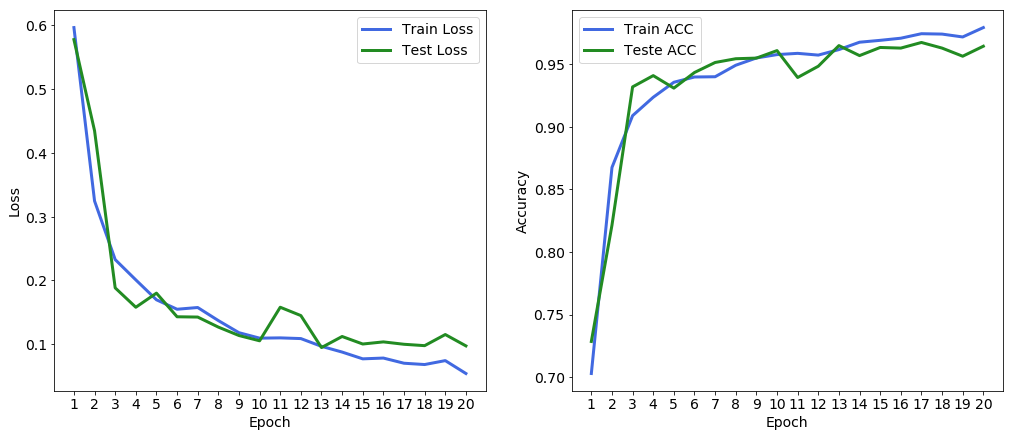

In [110]:
plot_acc(history_b_without_tuning)

Observando a matriz de confusão abaixo, nota-se que o modelo têm poucas dúvidas ao classificar as classes. Confirmando a baixa similaridade entre as classes existentes para a classificação.

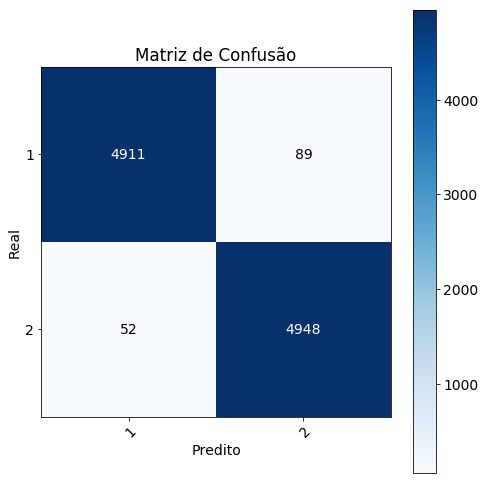

In [111]:
plot_confusion_matrix(cnn_model_b, b_x_train, b_y_train)

# 3 - Fine-tuning em  uma  camada - B2

Nesta parte iremos utilizar os pesos da rede treinada na parte A e realizar um fine-tuning na última camada totalmente conectada. Novamente, iremos utilizar os dados contidos na parte B para a avaliação da acurácia.

In [112]:
cnn_model_tuning1 = load_cnn_model(False, True)
cnn_model_tuning1.set_weights(cnn_model_a.get_weights())
history_b_tuning1 = execute_model(cnn_model_tuning1, b_x_train, b_y_train, b_x_test, b_y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 16, 16, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 64)        36928     
__________

## 3.1 -  Resultado -  B2

Com o Fine-tuning é possível notar novamente que o modelo continuou apresentando uma alta precisão **(96,85%)**. Outro fato é que já nas primeiras épocas executadas o modelo já atinge uma alta precisão. Isso se dá devido ao fine-tuning, com isso o modelo não precisa treinar toda a rede, apenas a camada final, fazendo com que o treinamento seja muito mais rápido, além de que, permite que o modelo foque em treinar apenas uma parte, possibilitando ganho na precisão final. De maneira geral, treinar a rede desde o início ou utilizar o Fine-tuning na última camada não fez muita diferença considerando os dados utilizados para a classificação. Como os exemplos Cavalo e Avião já são bem distintos, um modelo simples já consegue encontrar features que os diferencie com eficiência. Em contrapartida, caso fossemos utilizar imagens mais similares, como cachorro e gato, a utilização desta abordagem provavelmente iria propiciar um ganho na precisão, visto que o modelo já iria utilizar pesos calculados focando apenas no aprimoramento da camada final. Com isso, podemos concluir que utilizar o Fine-tuning apenas na última camada não trouxe ganhos consideráveis na precisão devido aos dados utilizados.

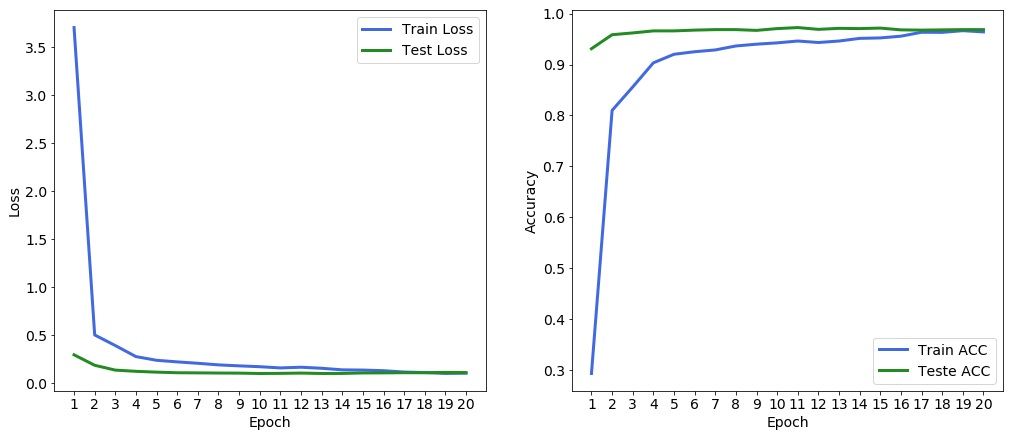

In [113]:
plot_acc(history_b_tuning1)

Observando novamente a matriz de confusão, nota-se que o modelo passou acertar mais classes se compararmos com a matriz da parte B1. Isso se deu devido o aprimoramento dos pesos da última camada. Assim, propiciando com que a rede aumente sua capacidade no acerto das classes.

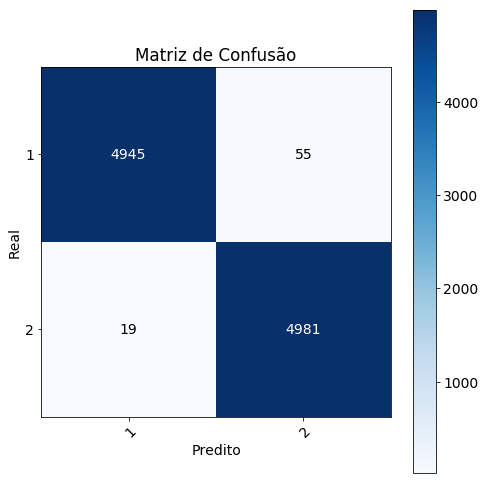

In [114]:
plot_confusion_matrix(cnn_model_tuning1, b_x_train, b_y_train)

# 4 - Fine-tuningem  duas  camadas - B3

Por fim, iremos nesta etapa utilizar os pesos da rede  treinada na parte A e realizar um fine-tuning nas duas camadas totalmente conectadas da rede. A diferença é que treinaremos apenas as duas últimas camadas existentes, em vez da rede completa como feito na parte A.

In [115]:
cnn_model_tuning2 = load_cnn_model(False, False)
cnn_model_tuning2.set_weights(cnn_model_a.get_weights())
history_b_tuning2 = execute_model(cnn_model_tuning2, b_x_train, b_y_train, b_x_test, b_y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 16, 16, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 64)        36928     
__________

## 4.1 - Resultado - B3

Novamente, o modelo apresentou boas taxas de precisão **(92,27%)**, assim como ocorreu em outras partes dos dados. De maneira semelhante, o modelo  utilizando Fine-tuning nas duas últimas camadas não apresentou resultados superiores se comparados aos valores obtidos sem Fine-tuning e com Fine-tuning apenas na última camada. Com isso, voltamos no ponto discutido na seção anterior, o modelo já atingiu uma taxa bem alta de precisão, sendo assim, melhorar um modelo que já possui **(96,45%)** é uma tarefa complexa, necessitando de mais épocas e outras técnicas. Além disto, observamos que ao utilizar o Fine-tuning foi possível treinar a rede muito mais rapidamente, além de que o modelo atinge uma boa precisão logo no início das épocas, apresentando poucas variações até finalizar a última época.

Outro ponto importante é que o modelo por mais que se dedicou em ajustar os pesos das últimas camadas, não sofreu overfitting.

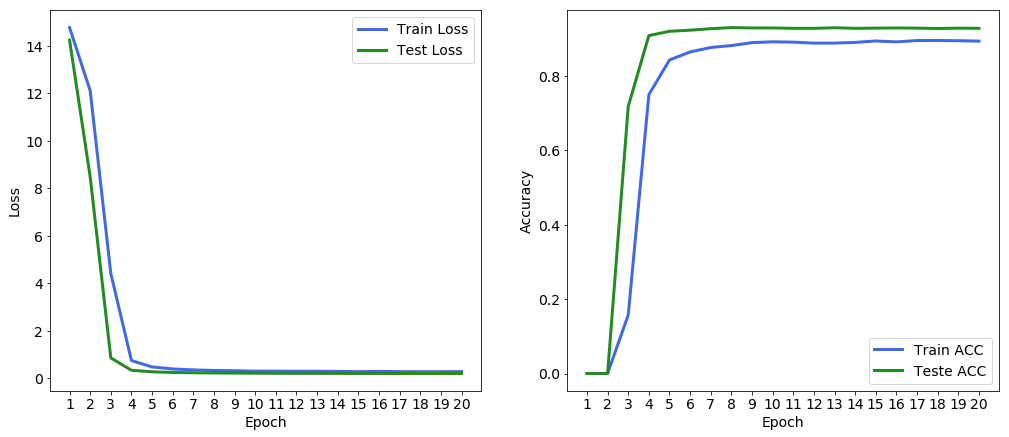

In [116]:
plot_acc(history_b_tuning2)

Observando a matriz de confusão, nota-se que o modelo classifica corretamente as duas classes existentes. Existem alguns exemplos que o modelo se "engana", mas na grande maioria das vezes acerta as classes. Como o problema pode ser considerado simples, o modelo tende a acertar muito mais do que errar, exatamente como mostrado na figura abaixo.

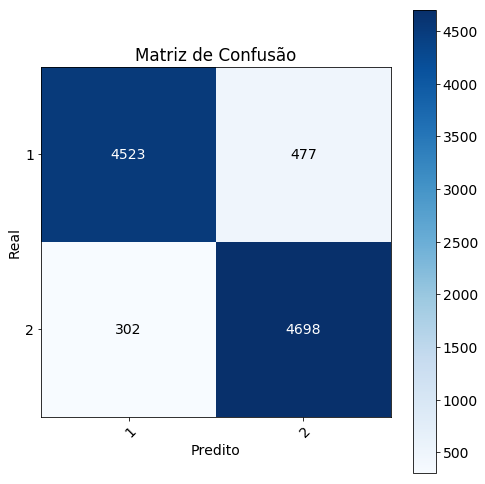

In [117]:
plot_confusion_matrix(cnn_model_tuning2, b_x_train, b_y_train)

# Conclusão

Observando o trabalho, de maneira geral o modelo construído conseguiu atingir bons valores de precisão. A CNN com  4 camadas de convolução e 4 de pooling se mostrou bastante eficiente.

Os dados utilizados foram separados em 2 partes, A e B. Abaixo segue os resultados obtidos em cada execução.


*   Na primeira parte (A), foi obtido uma acurácia  de 80,90%
*   Na parte (B) sem Fine-tuning foi obtido uma precisão de 96,45%
*   Na parte (B) com Fine-tuning apenas na última camada, alcançou-se uma precisão de 96,85%
*   Na parte (B) com Fine-tuning nas últimas duas camadas totalmente conectadas, obteve-se 92,27% de precisão


Em linhas gerais, os resultados apresentados pelos modelos que utilizaram Fine-tuning não se mostraram superiores se comparados a treinar a rede completa. Esse comportamento pode ter ocorrido devido a simplicidade do problema. Se observarmos a parte B, verificamos a existência imagens de cavalos e aviões, logo, classificá-los não é complexo, pois facilmente a rede encontra padrões que os diferencie. Assim, mesmo com Fine-Tuning, dificilmente os modelos irão superar a precisão que já é bastante alta 96,45%. Em contrapartida, mesmo que o Fine-Tuning não apresentou grandes alterações nos resultados, a técnica pode ser bastante útil em vários casos. Suponha que em vez de cavalos e aviões, fossem gatos e cachorros. Nota-se que a complexidade aumentou, assim, com Fine-Tuning é possível melhorar a performance da rede ajustando apenas os pesos das camadas finais.

Por fim, o problema não se mostrou complexo, visto que com poucas épocas e sem validação cruzada os modelos apresentaram uma precisão alta. Em complemento, vale a pena destacar o regularizador (decay), que ao ser adicionado proporcionou um grande aumento do desempenho das redes.
